# **Recommender System based Deep Learning TensorFlow RS for PetME!**




Install and import TFRS packages

In [1]:
!pip install git+https://github.com/Kaggle/learntools.git

  Cloning https://github.com/Kaggle/learntools.git to /tmp/pip-req-build-ab_l_xyj
  Running command git clone --filter=blob:none --quiet https://github.com/Kaggle/learntools.git /tmp/pip-req-build-ab_l_xyj
  Resolved https://github.com/Kaggle/learntools.git to commit 7a83948d1820d0282e518fc44692bb3118c9e1a6
  Preparing metadata (setup.py) ... done
  Created wheel for learntools: filename=learntools-0.3.4-py3-none-any.whl size=268963 sha256=e3600633653c6da4a6028f08233259ea2896a0386d759e2d88449963f9c7d399
  Stored in directory: /tmp/pip-ephem-wheel-cache-_d2yrqw5/wheels/2f/6c/3c/aa9f50cfb5a862157cb4c7a5b34881828cf45404698255dced
Successfully built learntools


In [2]:
import numpy as np
import pandas as pd
from datetime import datetime,timedelta

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.ticker import MaxNLocator
from learntools.time_series.utils import plot_periodogram, seasonal_plot # Kaggle Learning tools
from learntools.time_series.style import * # plot style settings

In [3]:
import seaborn as sns
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

In [16]:
from pathlib import Path
comp_dir = Path('pet')

Import data

In [13]:
!find /sample_data/

find: ‘/sample_data/’: No such file or directory


In [11]:
!pwd

/content


In [64]:
# This is pet dataset
pets_data=pd.read_csv(comp_dir / "user_rating.csv", dtype={'rating': 'int8'},
                             names=['userId', 'typeId','rating','timestamp'], index_col=None, header=0)
#pets_data.drop("timestamp",axis=1, inplace=True)
pets_data.head()

,userId,typeId,rating,timestamp
0,A2CX7LUOHB2NDG,001A,5,1341100800
1,A2NWSAGRHCP8N5,001A,1,1367193600
2,A2WNBOD3WNDNKT,001A,3,1374451200
3,A1GI0U4ZRJA8WN,001A,1,1334707200
4,A1QGNMC6O1VW39,002A,5,1397433600


In [65]:
printmd("**Number of Rating**: {:,}".format(pets_data.shape[0]) )
printmd("**Columns**: {}".format( np.array2string(pets_data.columns.values)) )
printmd("**Number of Users**: {:,}".format(len(pets_data.userId.unique()) ) )
printmd("**Number of Pets type**: {:,}".format(len(pets_data.typeId.unique())  ) )

**Number of Rating**: 16

**Columns**: ['userId' 'typeId' 'rating' 'timestamp']

**Number of Users**: 16

**Number of Pets type**: 5

In [66]:
pets_data.describe()['rating'].reset_index()

,index,rating
0,count,16.00000
1,mean,3.50000
2,std,1.75119
3,min,1.00000
4,25%,1.75000
5,50%,4.50000
6,75%,5.00000
7,max,5.00000


In [67]:
#Check for missing values
printmd('**Number of missing values**:')
pd.DataFrame(pets_data.isnull().sum().reset_index()).rename( columns={0:"Total missing","index":"Columns"})

**Number of missing values**:

,Columns,Total missing
0,userId,0
1,typeId,0
2,rating,0
3,timestamp,0


In [68]:
data_by_date = pets_data.copy()
data_by_date.timestamp = pd.to_datetime(pets_data.timestamp, unit="s")#.dt.date
data_by_date = data_by_date.sort_values(by="timestamp", ascending=False).reset_index(drop=True)
printmd("**Number of Ratings each day:**")
data_by_date.groupby("timestamp")["rating"].count().tail(10).reset_index()

**Number of Ratings each day:**

,timestamp,rating
0,2012-11-05,1
1,2013-04-29,1
2,2013-06-02,1
3,2013-07-22,1
4,2014-03-22,1
5,2014-03-23,1
6,2014-03-27,1
7,2014-04-14,2
8,2014-05-29,1
9,2014-07-18,1


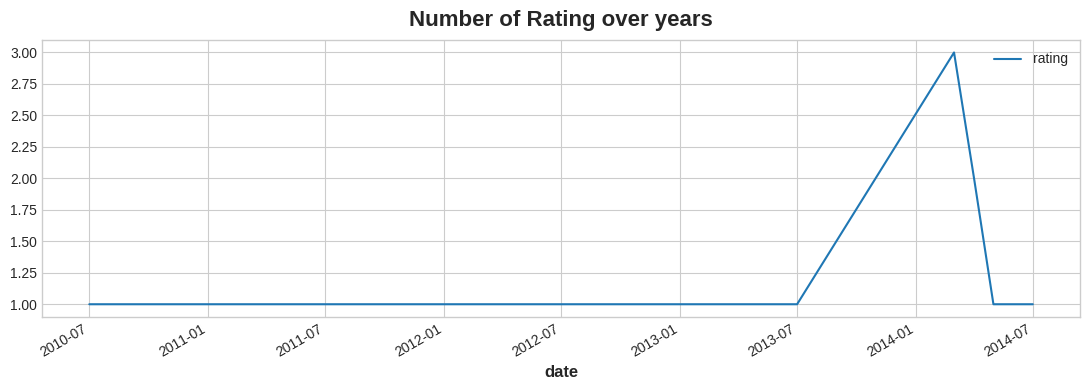

In [69]:
data_by_date["year"]  = data_by_date.timestamp.dt.year
data_by_date["month"] = data_by_date.timestamp.dt.month
rating_by_year = data_by_date.groupby(["year","month"])["rating"].count().reset_index()
rating_by_year["date"] = pd.to_datetime(rating_by_year["year"].astype("str")  +"-"+rating_by_year["month"].astype("str") +"-1")
rating_by_year.plot(x="date", y="rating")
plt.title("Number of Rating over years")
plt.show()

In [70]:
ratings = pets_data.groupby("rating").agg({"rating":"count"})

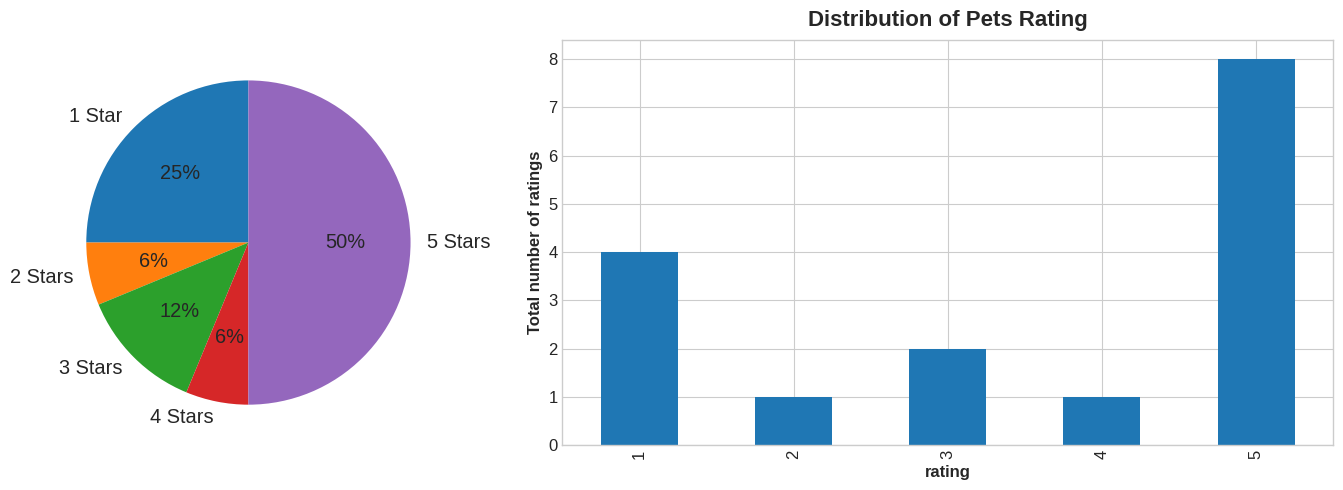

In [71]:
figsize = (15,5)
fig, (ax1,ax2) = plt.subplots(1,2,figsize=figsize)
ratings.plot.pie(ax=ax1,y="rating", legend=False, autopct='%1.f%%', startangle=90, fontsize="x-large",
                 labels=["1 Star","2 Stars","3 Stars","4 Stars","5 Stars"])
ax1.set_ylabel('')
ratings.plot.bar(ax=ax2,  fontsize="large")
ax2.set(ylabel="Total number of ratings")
ax2.set(title="Distribution of Pets Rating")
ax2.get_legend().remove()

# **Tensorflow Recommender**

Install and Import TFRS Packages

In [36]:
!pip install tensorflow_recommenders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.2/96.2 kB 2.9 MB/s eta 0:00:00


In [37]:
import numpy as np
import tensorflow as tf
import tensorflow_recommenders as tfrs

Build Models

In [72]:
class RankingModel(tf.keras.Model):

    def __init__(self):
        super().__init__()
        embedding_dimension = 32

        self.user_embeddings = tf.keras.Sequential([
                                    tf.keras.layers.experimental.preprocessing.StringLookup(
                                        vocabulary=unique_userIds, mask_token=None),
                                        # add addional embedding to account for unknow tokens
                                    tf.keras.layers.Embedding(len(unique_userIds)+1, embedding_dimension)
                                    ])

        self.product_embeddings = tf.keras.Sequential([
                                    tf.keras.layers.experimental.preprocessing.StringLookup(
                                        vocabulary=unique_productIds, mask_token=None),
                                    # add addional embedding to account for unknow tokens
                                    tf.keras.layers.Embedding(len(unique_productIds)+1, embedding_dimension)
                                    ])
        # Set up a retrieval task and evaluation metrics over the
        # entire dataset of candidates.
        self.ratings = tf.keras.Sequential([
                            tf.keras.layers.Dense(256, activation="relu"),
                            tf.keras.layers.Dense(64,  activation="relu"),
                            tf.keras.layers.Dense(1)
                              ])
    def call(self, userId, typeId):
        user_embeddings  = self.user_embeddings (userId)
        product_embeddings = self.product_embeddings(typeId)
        return self.ratings(tf.concat([user_embeddings,product_embeddings], axis=1))

# Build a model.
class amazonModel(tfrs.models.Model):

    def __init__(self):
        super().__init__()
        self.ranking_model: tf.keras.Model = RankingModel()
        self.task: tf.keras.layers.Layer   = tfrs.tasks.Ranking(
                                                    loss    =  tf.keras.losses.MeanSquaredError(),
                                                    metrics = [tf.keras.metrics.RootMeanSquaredError()])


    def compute_loss(self, features, training=False):
        rating_predictions = self.ranking_model(features["userId"], features["typeId"]  )

        return self.task( labels=features["rating"], predictions=rating_predictions)

In [73]:
cutoff_no_rat = 50    ## Only count products which received more than or equal 50
cutoff_year   = 2011  ## Only count Rating after 2011
recent_data   = data_by_date.loc[data_by_date["year"] > cutoff_year]
print("Number of Rating: {:,}".format(recent_data.shape[0]) )
print("Number of Users: {:,}".format(len(recent_data.userId.unique()) ) )
print("Number of Pets Types: {:,}".format(len(recent_data.typeId.unique())  ) )
del data_by_date  ### Free up memory ###
recent_prod   = recent_data.loc[recent_data.groupby("typeId")["rating"].transform('count').ge(cutoff_no_rat)].reset_index(
                    drop=True).drop(["timestamp","year","month"],axis=1)
del recent_data  ### Free up memory ###

Number of Rating: 13
Number of Users: 13
Number of Pets Types: 4


In [74]:
userIds    = recent_prod.userId.unique()
typeIds = recent_prod.typeId.unique()
total_ratings= len(recent_prod.index)

In [76]:
ratings = tf.data.Dataset.from_tensor_slices( {"userId":tf.cast( recent_prod.userId.values  ,tf.string),
                                "typeId":tf.cast( recent_prod.typeId.values,tf.string),
                                "rating":tf.cast( recent_prod.rating.values  ,tf.int8,) } )

In [77]:
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take( int(total_ratings*0.8) )
test = shuffled.skip(int(total_ratings*0.8)).take(int(total_ratings*0.2))

unique_typeIds = typeIds
unique_userIds    = userIds

Training models

In [78]:
model = amazonModel()
model.compile(optimizer=tf.keras.optimizers.Adagrad( learning_rate=0.1 ))
cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()
model.fit(cached_train, epochs=20)

ValueError: ignored

Evaluate Training Model

In [ ]:
model.evaluate(cached_test, return_dict=True)

Test Model

In [ ]:
user_rand = userIds[5]
test_rating = {}
for m in test.take(5):
    test_rating[m["productId"].numpy()]=RankingModel()(tf.convert_to_tensor([user_rand]),tf.convert_to_tensor([m["typeId"]]))

In [ ]:
print("Top 5 recommended pet types for User {}: ".format(user_rand))
for m in sorted(test_rating, key=test_rating.get, reverse=True):
    print(m.decode())